### Jak zapisywać modele, by wytrenować je raz, a potem na produkcji tylko ładować?

Skorzystamy z biblioteki joblib.

In [1]:
from sklearn.svm import SVC
from sklearn.model_selection import  train_test_split
from sklearn.metrics import f1_score
from sklearn.datasets import load_iris

iris_data = load_iris()
X, y = iris_data.data, iris_data.target
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

model = SVC(C=0.1, kernel='linear', max_iter=1000)
model.fit(X_train, y_train)

SVC(C=0.1, kernel='linear', max_iter=1000)

In [2]:
y_pred = model.predict(X_test)
f1_score(y_test, y_pred, average='macro')

0.9487179487179488

In [3]:
import joblib

model_filename = "model_svc.pkl"
joblib.dump(model, model_filename)

['model_svc.pkl']

In [4]:
model

SVC(C=0.1, kernel='linear', max_iter=1000)

In [5]:
import joblib
from sklearn.model_selection import  train_test_split
from sklearn.metrics import f1_score
from sklearn.datasets import load_iris

iris_data = load_iris()
X, y = iris_data.data, iris_data.target
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

In [6]:
model_filename = "model_svc.pkl"
model = joblib.load(model_filename)

In [7]:
model

SVC(C=0.1, kernel='linear', max_iter=1000)

In [8]:
y_pred = model.predict(X_test)
f1_score(y_test, y_pred, average='macro')

0.9487179487179488

**Ciekawostka:** [Jak zrobić TO (tj. dumpować model) przy użyciu biblioteki pickle](https://machinelearningmastery.com/save-load-machine-learning-models-python-scikit-learn/)

### Jak radzić sobie z wartościami kategorycznymi?

In [9]:
import pandas as pd

def load_dataset(filename, class_column, index_col=None):
    dataset = pd.read_csv(f'ML-datasets/{filename}.csv', index_col=index_col)
    dataset['class'] = dataset[class_column].astype('category').cat.codes
    classes = dataset.pop(class_column).unique()
    return dataset, classes

In [10]:
wine, wine_classes = load_dataset('wine', 'Class')
print(wine_classes)

y = wine.pop('class')
X = wine

['one' 'two' 'three']


In [11]:
X.head()

,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


Stwórzmy sobie najpierw zmienne typowo kategoryczne:

In [12]:
X['Moc'] = pd.cut(X['Alcohol'], 3, labels=['słabe', 'średnie', 'mocne'], duplicates='drop')
X['Kolor'] = pd.cut(X['Color intensity'], 3, labels=['białe', 'różowe', 'czerwone'], duplicates='drop')
X['Kwas jabłkowy'] = pd.cut(X['Malic acid'], 2, labels=['tak', 'nie'], duplicates='drop')

A następnie wszystkie cechy zamieńmy na one hot vectors

In [13]:
X = pd.get_dummies(X, columns=['Moc', 'Kolor', 'Kwas jabłkowy'], drop_first=True)

Możemy to też zrobić przy użyciu OneHotEncodera ze sklearna:

In [16]:
wine, wine_classes = load_dataset('wine', 'Class')

y = wine.pop('class')
X = wine

X['Moc'] = pd.cut(X['Alcohol'], 3, labels=['słabe', 'średnie', 'mocne'], duplicates='drop')
X['Kolor'] = pd.cut(X['Color intensity'], 3, labels=['białe', 'różowe', 'czerwone'], duplicates='drop')
X['Kwas jabłkowy'] = pd.cut(X['Malic acid'], 2, labels=['tak', 'nie'], duplicates='drop')

In [17]:
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse_output = False)

X_onehot = one_hot_encoder.fit_transform(X[['Moc', 'Kolor', 'Kwas jabłkowy']])

X_onehot_df = pd.DataFrame(X_onehot, 
                           columns=one_hot_encoder.get_feature_names_out(['Moc', 'Kolor', 'Kwas jabłkowy']))


Target encoding:

In [18]:
df = pd.concat([X,y], axis = 1)

means = df.groupby('Moc')['class'].mean()
df['Moc'] = df['Moc'].map(means)

display(df)

,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline,Moc,Kolor,Kwas jabłkowy,class
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065,0.294118,różowe,tak,0
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050,1.116279,białe,tak,0
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185,1.116279,różowe,tak,0
3,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480,0.294118,różowe,tak,0
4,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735,1.116279,białe,tak,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,13.71,5.65,2.45,20.5,95,1.68,0.61,0.52,1.06,7.70,0.64,1.74,740,0.294118,różowe,nie,1
174,13.40,3.91,2.48,23.0,102,1.80,0.75,0.43,1.41,7.30,0.70,1.56,750,1.116279,różowe,nie,1
175,13.27,4.28,2.26,20.0,120,1.59,0.69,0.43,1.35,10.20,0.59,1.56,835,1.116279,czerwone,nie,1
176,13.17,2.59,2.37,20.0,120,1.65,0.68,0.53,1.46,9.30,0.60,1.62,840,1.116279,czerwone,tak,1


### Jak radzić sobie z niezbalansowanym zbiorem?

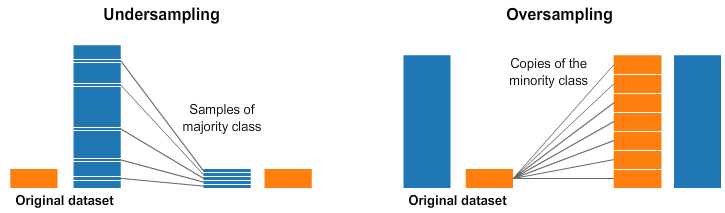

Stwórzmy syntetyczny niezbalansowany zbiór:

In [19]:
from sklearn.datasets import make_classification

X, y = make_classification(n_samples=1000, n_features=20,  weights=[0.8, 0.2], random_state=42)
df = pd.DataFrame(X, columns=[f"feat_{i}" for i in range(20)])
df['class'] = y

In [20]:
df.head()

,feat_0,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,...,feat_11,feat_12,feat_13,feat_14,feat_15,feat_16,feat_17,feat_18,feat_19,class
0,-0.669356,-0.198069,-0.870766,1.141831,0.021606,-1.086403,-1.251698,0.289305,0.357163,-0.196811,...,0.154850,-0.219970,-0.739137,1.646000,1.634606,-0.938180,-1.267337,0.261736,1.016643,0
1,0.093372,0.785848,0.105754,1.272354,-0.846316,-0.979093,1.263707,0.264020,2.411677,-0.960046,...,0.199810,0.288724,0.732492,-0.872002,-1.654887,-1.130204,-0.122709,0.693431,0.911363,0
2,-0.905797,-0.608341,0.295141,0.943716,0.092936,1.370397,-0.064772,0.287273,-0.533004,-0.032504,...,-0.510064,-0.868768,-0.598279,0.019832,0.613460,-1.779439,0.830498,-0.737332,-0.578212,1
3,-0.585793,0.572040,0.698816,0.436236,-0.315082,-0.471095,1.448820,0.505558,-1.440982,-1.134020,...,1.466783,0.678728,-1.190917,-0.893229,-0.929136,-0.221600,-0.346772,0.425658,-1.040199,0
4,1.146441,0.515579,-1.222895,-0.396230,-1.293508,-0.352428,0.071254,1.239584,1.007133,-1.479444,...,-0.918127,0.604121,1.068379,-0.882271,2.303639,-0.973379,1.259233,0.360015,1.920368,0


In [21]:
df['class'].value_counts()

0    798
1    202
Name: class, dtype: int64

Wytrenujmy na tym model SVM

In [22]:
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

In [23]:
X = df[[f"feat_{i}" for i in range(20)]]
y = df['class']

In [24]:
X = df[[f"feat_{i}" for i in range(20)]]
y = df['class']

X_rest, X_final, y_rest, y_final = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

Metoda extend() w Pythonie jest używana do dodawania elementów z listy (lub dowolnego iterowalnego) do innej listy. Różnica między extend() a append() polega na tym, że extend() dodaje elementy z listy jako pojedyncze elementy, podczas gdy append() dodaje całą listę jako jeden element.

In [25]:
true, predicted = [], []

for train_index, test_index in StratifiedKFold(5).split(X_rest, y_rest):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    model_svm = SVC()
    model_svm.fit(X_train, y_train)
    true.extend(y_test)
    predicted.extend(model_svm.predict(X_test))

print(classification_report(true, predicted))

              precision    recall  f1-score   support

           0       0.93      0.97      0.95       636
           1       0.85      0.71      0.77       164

    accuracy                           0.91       800
   macro avg       0.89      0.84      0.86       800
weighted avg       0.91      0.91      0.91       800



In [26]:
model_svm = SVC()
model_svm.fit(X_rest, y_rest)
y_pred = model_svm.predict(X_final)
print(classification_report(y_final, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.96      0.95       160
           1       0.82      0.78      0.79        40

    accuracy                           0.92       200
   macro avg       0.88      0.87      0.87       200
weighted avg       0.92      0.92      0.92       200



<Axes: >

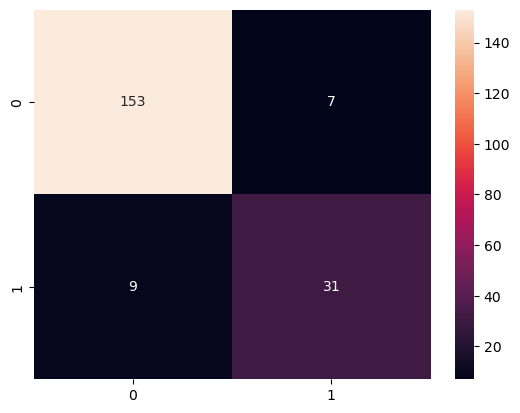

In [27]:
import seaborn as sns
cm = confusion_matrix(y_final, y_pred)
sns.heatmap(cm, annot=True, fmt='d')

#### Oversampling

In [28]:
from sklearn.utils import resample

In [29]:
df = pd.DataFrame(X_rest, columns=[f"feat_{i}" for i in range(20)])
df['class'] = y_rest

In [30]:
df['class'].value_counts()

0    638
1    162
Name: class, dtype: int64

In [31]:
df_majority = df[df['class'] == 0]
df_minority = df[df['class'] == 1]

# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,    # sample with replacement
                                 n_samples=638,    # to match majority class
                                 random_state=42) # reproducible results
 
# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
 
# Display new class counts
df_upsampled['class'].value_counts()

0    638
1    638
Name: class, dtype: int64

In [32]:
df.merge(df_upsampled[df_upsampled['class'] == 1].drop_duplicates(), on = list(df.columns[:-1]), how = 'right')

,feat_0,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,...,feat_12,feat_13,feat_14,feat_15,feat_16,feat_17,feat_18,feat_19,class_x,class_y
0,-0.234508,0.163804,0.227405,-1.034598,-0.960780,0.157920,-0.889845,0.391881,0.501129,-0.784321,...,0.425911,0.650668,-0.569031,-1.070666,1.589147,0.688496,0.026012,0.867805,1,1
1,-1.228945,-0.612212,-0.717499,0.106435,-0.107127,0.733345,-0.965575,-0.182315,0.596794,0.720357,...,0.936806,1.268359,0.710796,1.219943,0.149872,0.332613,-0.530584,0.707106,1,1
2,-0.818525,-1.015682,0.751091,1.312549,-0.152377,1.153597,0.041386,0.196272,0.526548,0.328767,...,0.623600,0.344134,1.246686,1.583718,2.022213,-0.122655,-0.859614,0.586453,1,1
3,1.676455,-0.078133,1.587401,1.071476,0.165859,0.494788,0.399997,-0.457677,-0.600887,0.203944,...,0.323247,-1.109750,-0.338478,-1.547570,-1.564974,0.192990,-0.199075,-0.302097,1,1
4,0.336500,-0.549477,-0.307048,-2.521605,0.106494,3.547011,1.143566,0.197676,0.407090,0.891701,...,0.391829,0.428353,-2.452455,0.020121,-1.566959,-0.672394,-1.422074,-0.462737,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
153,0.482534,-0.429443,0.444968,-0.331865,-0.161767,1.714153,0.031063,0.609239,0.747546,0.168231,...,0.479940,0.324782,-0.784869,-1.007195,0.660343,-2.161304,-0.765005,1.396760,1,1
154,0.037647,0.448819,0.404049,0.885527,-0.852768,-0.472745,1.798415,-1.542193,1.608077,-0.685473,...,0.283678,0.463270,-0.590499,0.426790,1.161211,-1.005695,0.367734,0.521004,1,1
155,0.063702,0.708144,-0.097311,1.496880,-0.692065,1.193560,-0.298153,-0.076239,-0.292758,0.374062,...,-0.240724,-0.611085,-3.006486,-1.701140,-0.216827,0.264482,-0.054811,2.004423,1,1
156,1.590835,-1.068700,1.318608,0.532596,-0.784112,1.170129,-1.117894,-1.521433,-0.408500,0.160259,...,1.789791,-0.547218,1.358496,0.296185,0.358554,-0.369244,-0.890183,1.031043,1,1


In [33]:
df['class'].value_counts()

0    638
1    162
Name: class, dtype: int64

In [34]:
df_upsampled['class'].value_counts()

0    638
1    638
Name: class, dtype: int64

Sprawdźmy, czy nasz model na takim zbiorze zwróci lepsze rezultaty

In [35]:
X = df_upsampled[[f"feat_{i}" for i in range(20)]]
y = df_upsampled['class']

true, predicted = [], []

for train_index, test_index in StratifiedKFold(5).split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    model_svm = SVC()
    model_svm.fit(X_train, y_train)
    true.extend(y_test)
    predicted.extend(model_svm.predict(X_test))

print(classification_report(true, predicted))

              precision    recall  f1-score   support

           0       0.95      0.93      0.94       638
           1       0.93      0.95      0.94       638

    accuracy                           0.94      1276
   macro avg       0.94      0.94      0.94      1276
weighted avg       0.94      0.94      0.94      1276



In [36]:
model_svm = SVC()
model_svm.fit(X, y)
y_pred = model_svm.predict(X_final)
print(classification_report(y_final, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.91      0.94       160
           1       0.71      0.88      0.79        40

    accuracy                           0.91       200
   macro avg       0.84      0.89      0.86       200
weighted avg       0.92      0.91      0.91       200



<Axes: >

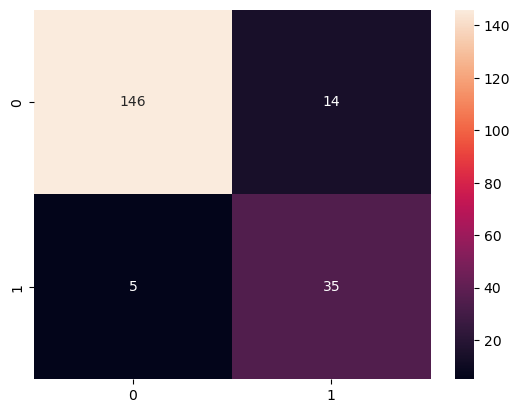

In [37]:
cm = confusion_matrix(y_final, y_pred)
sns.heatmap(cm, annot=True, fmt='d')

#### Undersampling

In [38]:
df = pd.DataFrame(X_rest, columns=[f"feat_{i}" for i in range(20)])
df['class'] = y_rest

In [39]:
df['class'].value_counts()

0    638
1    162
Name: class, dtype: int64

In [40]:
df_majority = df[df['class'] == 0]
df_minority = df[df['class'] == 1]

# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                   replace=False,    # sample with replacement
                                   n_samples=162,    # to match majority class
                                   random_state=42)  # reproducible results
 
# Combine majority class with upsampled minority class
df_downsampled = pd.concat([df_minority, df_majority_downsampled])
 
# Display new class counts
df_downsampled['class'].value_counts()

1    162
0    162
Name: class, dtype: int64

Sprawdźmy, czy nasz model na takim zbiorze zwróci lepsze rezultaty

In [41]:
X = df_downsampled[[f"feat_{i}" for i in range(20)]]
y = df_downsampled['class']

true, predicted = [], []

for train_index, test_index in StratifiedKFold(5).split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    model_svm = SVC()
    model_svm.fit(X_train, y_train)
    true.extend(y_test)
    predicted.extend(model_svm.predict(X_test))

print(classification_report(true, predicted))

              precision    recall  f1-score   support

           0       0.84      0.91      0.87       162
           1       0.90      0.82      0.86       162

    accuracy                           0.87       324
   macro avg       0.87      0.87      0.87       324
weighted avg       0.87      0.87      0.87       324



In [42]:
model_svm = SVC()
model_svm.fit(X, y)
y_pred = model_svm.predict(X_final)
print(classification_report(y_final, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.88      0.93       160
           1       0.66      0.93      0.77        40

    accuracy                           0.89       200
   macro avg       0.82      0.90      0.85       200
weighted avg       0.92      0.89      0.90       200



<Axes: >

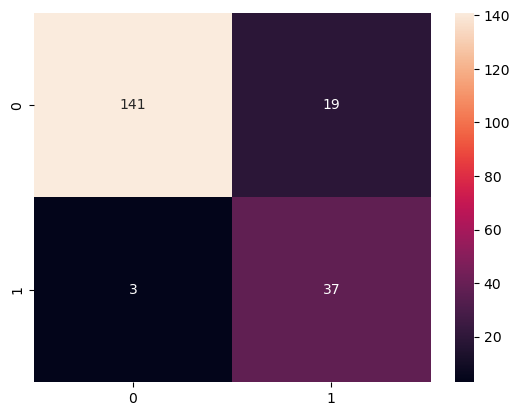

In [43]:
cm = confusion_matrix(y_final, y_pred)
sns.heatmap(cm, annot=True, fmt='d')